# Transient Groundwater Models

Transient (non-equilibrium) models use the same differencing approach, but the time derivative is no longer zero, so the iterative solution occurs within individual time steps. 

## Confined Aquifers

Starting with

$$
S \frac{\partial h}{\partial t} = 
\frac{\partial}{\partial x}({T_x \frac{\partial h}{\partial x}}) +
\frac{\partial}{\partial y}({T_y \frac{\partial h}{\partial y}}) + R - Q
$$

the right hand side is approximated first

$$ 
S \frac{\partial h_{i,j}}{\partial t} = [ \frac{1}{\Delta x} T_x \frac{h_{i−1,j} − h_{i,j}}{\Delta x} + \frac{1}{\Delta y} T_y \frac{h_{i,j-1} − h_{i,j}}{\Delta y}]-[\frac{1}{\Delta x} T_x \frac{h_{i,j} − h_{i+1,j}}{\Delta x} + \frac{1}{\Delta y} T_y \frac{h_{i,j} − h_{i,j+1}}{\Delta y}] + \frac{R_{i,j}}{\Delta x \Delta y} - \frac{Q_{i,j}}{\Delta x \Delta y}
$$

then the left hand side is approximated by a first-order difference in time as

$$
S \frac{\partial h_{i,j}}{\partial t} ~\approx S \frac{h^{t+\Delta t}_{i,j} - h^{t}_{i,j}}{\Delta t}
$$

Substitute to obtain

$$ 
S \frac{h^{t+\Delta t}_{i,j} - h^{t}_{i,j}}{\Delta t} = [ \frac{1}{\Delta x} T_x \frac{h_{i−1,j} − h_{i,j}}{\Delta x} + \frac{1}{\Delta y} T_y \frac{h_{i,j-1} − h_{i,j}}{\Delta y}]-[\frac{1}{\Delta x} T_x \frac{h_{i,j} − h_{i+1,j}}{\Delta x} + \frac{1}{\Delta y} T_y \frac{h_{i,j} − h_{i,j+1}}{\Delta y}] + \frac{R_{i,j}}{\Delta x \Delta y} - \frac{Q_{i,j}}{\Delta x \Delta y}
$$

Isolate the update term and we have an **explicit** method, which is easy to program, but unstable if $\Delta t$ is too large.

$$ 
h^{t+\Delta t}_{i,j} = h^{t}_{i,j} + [ \frac{\Delta t}{S \Delta x} T_x \frac{h^{t}_{i−1,j} − h^{t}_{i,j}}{\Delta x} + \frac{\Delta t}{S \Delta y} T_y \frac{h^{t}_{i,j-1} − h^{t}_{i,j}}{\Delta y}]-[\frac{\Delta t}{S \Delta x} T_x \frac{h^{t}_{i,j} − h^{t}_{i+1,j}}{\Delta x} + \frac{\Delta t}{S \Delta y} T_y \frac{h^{t}_{i,j} − h^{t}_{i,j+1}}{\Delta y}] + \frac{\Delta t R_{i,j}}{S \Delta x \Delta y} - \frac{\Delta t Q_{i,j}}{S \Delta x \Delta y}
$$

An **implicit** method that is unconditionally stable and can use our already built iterative tools is

$$ 
h^{t+\Delta t}_{i,j} = h^{t}_{i,j} + [ \frac{\Delta t}{S \Delta x} T_x \frac{h^{\Delta t}_{i−1,j} − h^{\Delta t}_{i,j}}{\Delta x} + \frac{\Delta t}{S \Delta y} T_y \frac{h^{\Delta t}_{i,j-1} − h^{\Delta t}_{i,j}}{\Delta y}]-[\frac{\Delta t}{S \Delta x} T_x \frac{h^{\Delta t}_{i,j} − h^{\Delta t}_{i+1,j}}{\Delta x} + \frac{\Delta t}{S \Delta y} T_y \frac{h^{\Delta t}_{i,j} − h^{\Delta t}_{i,j+1}}{\Delta y}] + \frac{\Delta t R^{t}_{i,j}}{S \Delta x \Delta y} - \frac{\Delta t Q^{t}_{i,j}}{S \Delta x \Delta y}
$$

:::{note}
While the implicit method is unconditionally stable, its accuracy is dependent on the ratios of time steps and space steps and may still need to employ short time steps to obtain a meaningful result
:::

Observe a very important part of the difference equation, $h^t_{i,j}$
is known at the beginning of a time step and does not change during the computation effort for that time period – it is just another constant like recharge or pumping. However, once we have the
update, then it is changed and the next time step is begun. The observation is
important to remember because we are simply going to wrap a time stepping loop
around our already tested and working Jacobi solver.

Employing the same $A, B, C, D$ structure as the unsteady 2D solvers we built the
update model is

$$
A_{i,j} = \frac{\Delta t}{2 S_{i,j}∆x^2} (T_{x,(i−1,j)}  + T_{x,(i,j)} )\\
B_{i,j} = \frac{\Delta t}{2 S_{i,j}∆x^2} (T_{x,(i,j)}  + T_{x,(i+1,j)} )\\
C_{i,j} = \frac{\Delta t}{2 S_{i,j}∆y^2} (T_{y,(i,j−1)}  + T_{y,(i,j)} )\\
D_{i,j} = \frac{\Delta t}{2 S_{i,j}∆y^2} (T_{y,(i,j)}  + T_{y,(i,j+1)} )\\
E_{i,j} = \frac{\Delta t}{2 S_{i,j}∆y^2}
$$

The last term $E$ is for the pumping term

The difference equation after substitution

$$
h^{t+\Delta t}_{i,j} = \frac{[A_{i,j} h^{t+\Delta t}_{i−1,j} + B_{i,j} h^{t+\Delta t}_{i+1,j} + C_{i,j} h^{t+\Delta t}_{i,j−1} + D_{i,j} h^{t+\Delta t}_{i,j+1}]+ h^{t}_{i,j} + E_{i,j}[R^{t}_{i,j} - Q^{t}_{i,j}]}{[A_{i,j} + B_{i,j} + C_{i,j} + D_{i,j} + 1]} 
$$

This equation is quite amenable to the Jacobi iteration technique, with the addition
of the two right-most terms for head at the start of the time step and the net recharge
less pumping. 
Notice the +1 in the denominator of the weighting term – it reflects
that $h^{t+∆t}_{i,j}$ appears on both the left and right hand side of the equation.
Listing 71 is an R script that implements these changes. In the script the plotting
has been moved into the prototype function, so we can generate a plot when we wish.
The input data reading portion has a line added to capture the time step length,
the maximum number of time steps to take, a printing frequency (make a plot every
iprint time steps), and a storage coefficient array. Observe that the printing test
makes use of the MODULO construct in R.

### Homebrew - Example 7: Rectangular Aquifer with Pumping – Unsteady Flow 
{numref}`hubbleville` is a plan view of a confined aquifer with a well field located as shown, near the Red River. 

```{figure} hubbleville.png
---
width: 400px
name: hubbleville
---
Plan view schematic of Hubbleville aquifer system.
```

The head in the river is 1000 meters as is the head at the South boundary, the
Green Swamp. The aquifer thickness is about $10$ meters. The hydraulic conductivity
of the water producing zone is $20$ meters per day. Determine the head distribution
every 1/2 year of pumping at a rate of $20,000$ cubic meters per day for 3 years. 
The storage coefficient of the aquifer is $S = 0.01$.

**input7.txt** Input file for the Hubbleville Aquifer Example. Annotations in the listing need to be re-
moved for actual running of the file and are included to illustrate the various parts of the input data.
```
1000 <== Delta x
1000 <== Delta y
10 <== Delta z ( thickness )
0.1 <== Time step length ( in days )
10 <== row count
10 <== column count
1e-4 <== tolerance for linear solver
100 <== how many trials per linear system
10950 <== how many time steps
1825 <== print every ## time step
0 1000 2000 3000 4000 5000 6000 7000 8000 9000
0 1000 2000 3000 4000 5000 6000 7000 8000 9000
1 1 1 1 1 1 1 1 1 1 <== boundary conditions
1 1 1 1 1 1 1 1 1 1
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 <== initial head array
1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
20 20 20 20 20 20 20 20 20 20 20 20 <== Kx array
20 20 20 20 20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20 20 20 20 20 <== Ky array
20 20 20 20 20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20 20 20 20 20
0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 <== Storage coefficient
0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.11
0 0 0 0 0 0 0 0 0 0 <== pumping array
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 20000 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
```

0xffff81456c00 0xffff813f6240
Elapsed Time  0.1  days
Closure Error =  3.09976e-07
Iterations Last Step = 1
Minimum Head 999.802
Pumpage Total 2000.0  cubic meters
Head End of Timestep 
 ----
0 [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
1 [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
2 [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
3 [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
4 [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
5 [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
6 [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
7 [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
8 [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
9 [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
--------
--------
0xffff81456c00 0xffff813f6240


Elapsed Time  182.1  days
Closure Error =  0.000394493645
Iterations Last Step = 0
Minimum Head 959.302
Pumpage Total 3642000.0  cubic meters
Head End of Timestep 
 ----
0 [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
1 [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
2 [1000. 1000. 1000.  999.  999.  999. 1000. 1000. 1000. 1000.]
3 [ 999.  999.  999.  999.  998.  999.  999.  999. 1000. 1000.]
4 [998. 998. 998. 997. 996. 997. 998. 999. 999. 999.]
5 [997. 997. 996. 994. 992. 994. 996. 998. 999. 999.]
6 [996. 996. 994. 989. 983. 989. 994. 997. 998. 998.]
7 [996. 996. 992. 983. 959. 984. 993. 997. 998. 998.]
8 [997. 997. 996. 991. 986. 992. 996. 998. 999. 999.]
9 [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
--------
--------
0xffff81456c00 0xffff813f6240


Elapsed Time  364.1  days
Closure Error =  0.000308454755
Iterations Last Step = 1
Minimum Head 955.806
Pumpage Total 7282000.0  cubic meters
Head End of Timestep 
 ----
0 [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
1 [999. 999. 999. 999. 999. 999. 999. 999. 999. 999.]
2 [998. 998. 998. 998. 998. 998. 998. 999. 999. 999.]
3 [997. 997. 997. 996. 996. 996. 997. 998. 998. 998.]
4 [995. 995. 995. 994. 993. 994. 995. 996. 997. 997.]
5 [993. 993. 992. 990. 988. 990. 993. 995. 996. 996.]
6 [992. 992. 990. 985. 979. 985. 991. 994. 996. 996.]
7 [992. 992. 989. 980. 956. 980. 990. 994. 996. 996.]
8 [995. 995. 994. 989. 984. 990. 994. 997. 998. 998.]
9 [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
--------
--------
0xffff81456c00 0xffff813f6240


Elapsed Time  546.1  days
Closure Error =  0.000340195044
Iterations Last Step = 0
Minimum Head 954.199
Pumpage Total 10922000.0  cubic meters
Head End of Timestep 
 ----
0 [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
1 [998. 998. 998. 998. 998. 999. 999. 999. 999. 999.]
2 [997. 997. 997. 997. 997. 997. 997. 997. 998. 998.]
3 [995. 995. 995. 994. 994. 995. 995. 996. 996. 996.]
4 [993. 993. 992. 991. 991. 992. 993. 995. 995. 995.]
5 [991. 991. 990. 988. 986. 988. 991. 993. 994. 994.]
6 [990. 990. 987. 983. 977. 983. 989. 992. 994. 994.]
7 [991. 991. 987. 978. 954. 979. 989. 993. 995. 995.]
8 [995. 995. 993. 988. 983. 989. 993. 996. 997. 997.]
9 [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
--------
--------
0xffff81456c00 0xffff813f6240


Elapsed Time  728.1  days
Closure Error =  0.000218023617
Iterations Last Step = 1
Minimum Head 953.256
Pumpage Total 14562000.0  cubic meters
Head End of Timestep 
 ----
0 [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
1 [998. 998. 998. 998. 998. 998. 998. 998. 998. 998.]
2 [996. 996. 996. 996. 996. 996. 996. 997. 997. 997.]
3 [994. 994. 993. 993. 993. 993. 994. 995. 995. 995.]
4 [991. 991. 991. 990. 990. 991. 992. 993. 994. 994.]
5 [990. 990. 988. 986. 984. 987. 990. 992. 993. 993.]
6 [989. 989. 986. 981. 975. 982. 988. 991. 993. 993.]
7 [990. 990. 986. 977. 953. 978. 988. 992. 994. 994.]
8 [994. 994. 992. 988. 982. 988. 993. 995. 996. 996.]
9 [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
--------
--------
0xffff81456c00 0xffff813f6240


Elapsed Time  910.1  days
Closure Error =  0.000489030327
Iterations Last Step = 0
Minimum Head 952.665
Pumpage Total 18202000.0  cubic meters
Head End of Timestep 
 ----
0 [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
1 [998. 998. 998. 998. 998. 998. 998. 998. 998. 998.]
2 [995. 995. 995. 995. 995. 995. 996. 996. 996. 996.]
3 [993. 993. 993. 992. 992. 993. 993. 994. 995. 995.]
4 [991. 991. 990. 989. 989. 990. 991. 992. 993. 993.]
5 [989. 989. 987. 985. 984. 986. 989. 991. 992. 992.]
6 [988. 988. 985. 980. 975. 981. 987. 990. 992. 992.]
7 [989. 989. 986. 977. 953. 977. 987. 991. 993. 993.]
8 [994. 994. 992. 988. 982. 988. 993. 995. 996. 996.]
9 [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
--------
--------
0xffff81456c00 0xffff813f6240


Elapsed Time  1092.1  days
Closure Error =  0.00089839574
Iterations Last Step = 0
Minimum Head 952.288
Pumpage Total 21842000.0  cubic meters
Head End of Timestep 
 ----
0 [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
1 [997. 997. 997. 997. 997. 998. 998. 998. 998. 998.]
2 [995. 995. 995. 995. 995. 995. 995. 996. 996. 996.]
3 [992. 992. 992. 992. 992. 992. 993. 994. 994. 994.]
4 [990. 990. 989. 989. 988. 989. 991. 992. 992. 992.]
5 [988. 988. 987. 985. 983. 985. 988. 990. 991. 991.]
6 [987. 987. 985. 980. 974. 981. 986. 990. 991. 991.]
7 [989. 989. 985. 976. 952. 977. 987. 991. 993. 993.]
8 [993. 993. 992. 987. 982. 988. 992. 995. 996. 996.]
9 [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
--------
--------
0xffff81456c00 0xffff813f6240


End Simulation


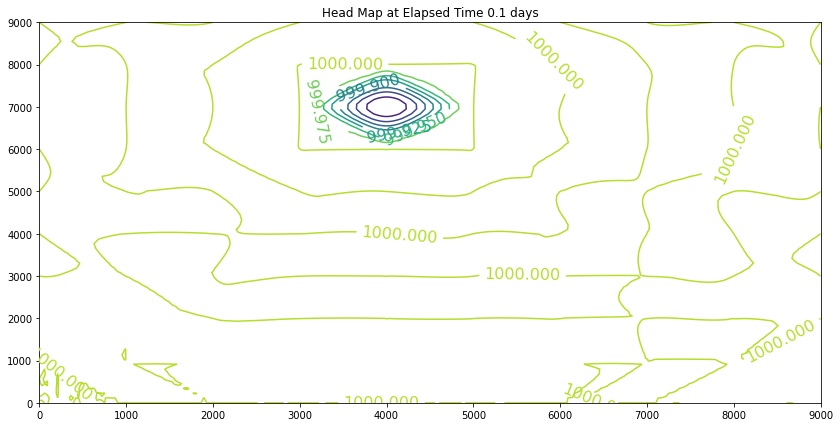

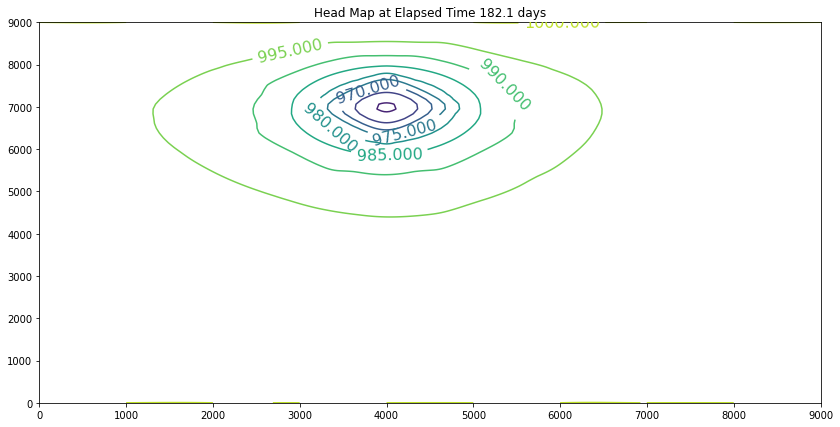

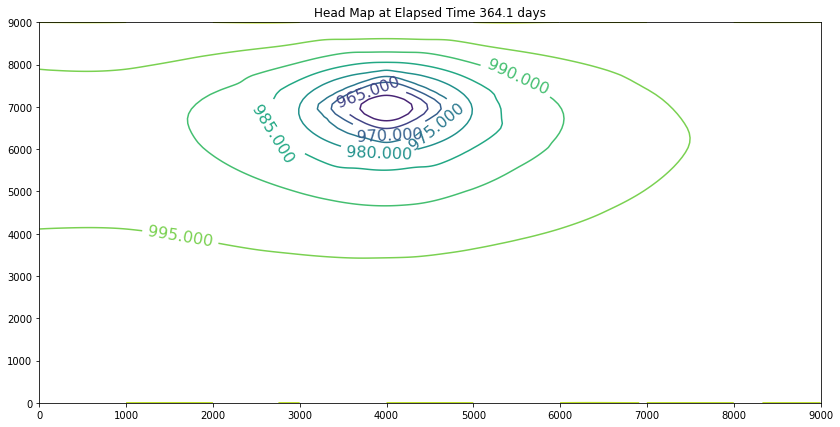

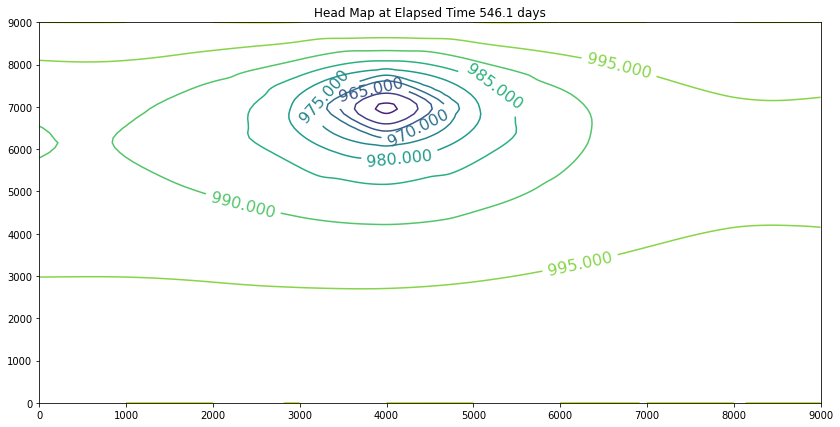

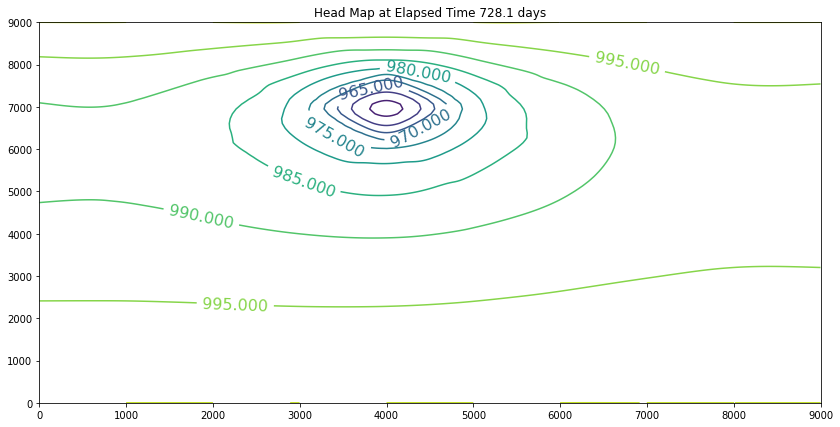

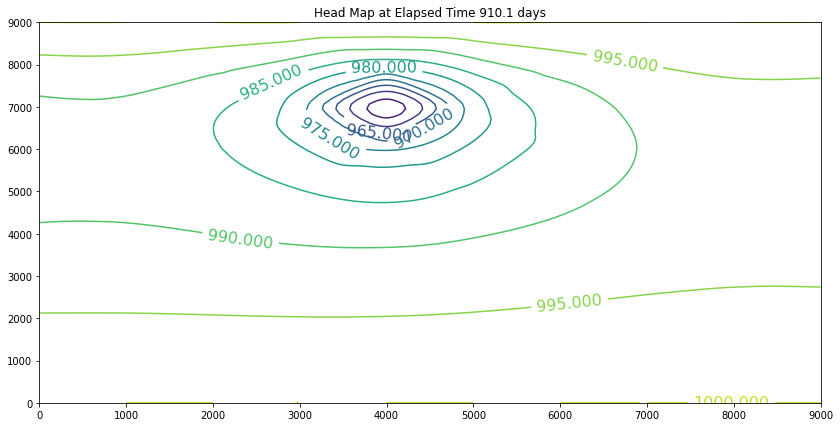

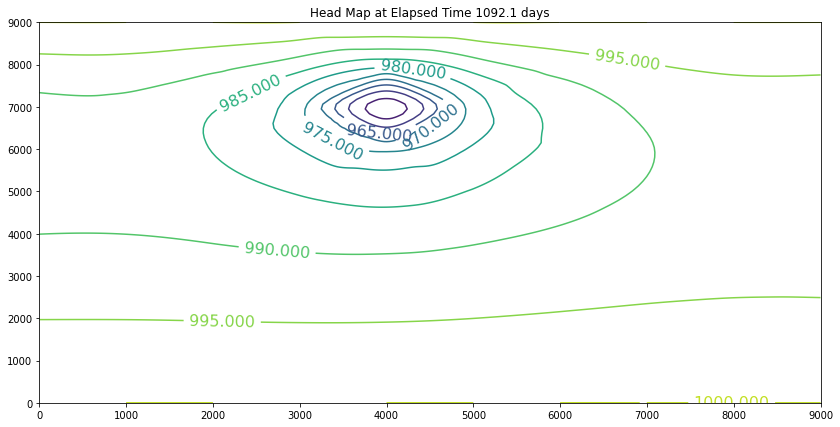

In [1]:
%reset -f

def sse(matrix1,matrix2):
    sse=0.0
    nr=len(matrix1) # get row count
    nc=len(matrix1[0]) # get column count
    for ir in range(nr):
        for jc in range(nc):
            sse=sse+(matrix1[ir][jc]-matrix2[ir][jc])**2
    return(sse)

def update(matrix1,matrix2):
    nr=len(matrix1) # get row count
    nc=len(matrix1[0]) # get column count
    ##print(nr,nc)
    for ir in range(nr):
        for jc in range(nc):
            ##print(ir,jc)
            matrix2[ir][jc]=matrix1[ir][jc]
    return(matrix2)

def writearray(matrix):
    nr=len(matrix) # get row count
    nc=len(matrix[0]) # get column count
    import numpy as np
    new_list = list(np.around(np.array(matrix), 0))    
    for ir in range(nr):
        print(ir,new_list[ir][:])
    return()
import numpy 
localfile = open("input7.txt","r") # connect and read file for 2D gw model
deltax = float(localfile.readline())
deltay = float(localfile.readline())
deltaz = float(localfile.readline())
deltat = float(localfile.readline()) # time step
nrows = int(localfile.readline())
ncols = int(localfile.readline())
tolerance = float(localfile.readline())
maxiter = int(localfile.readline()) # max iter per time step
maxtime = int(localfile.readline()) # total time steps
iprint = int(localfile.readline()) # output every iprint steps
distancex = [] # empty list
distancex.append([float(n) for n in localfile.readline().strip().split()])
distancey = [] # empty list
distancey.append([float(n) for n in localfile.readline().strip().split()])
boundarytop = [] #empty list
boundarytop.append([float(n) for n in localfile.readline().strip().split()])
boundarybottom = [] #empty list
boundarybottom.append([int(n) for n in localfile.readline().strip().split()])
boundaryleft = [] #empty list
boundaryleft.append([int(n) for n in localfile.readline().strip().split()])
boundaryright = [] #empty list
boundaryright.append([int(n) for n in localfile.readline().strip().split()])
head =[] # empty list
for irow in range(nrows):
        head.append([float(n) for n in localfile.readline().strip().split()])
#writearray(head)
hydcondx = [] # empty list
for irow in range(nrows):
        hydcondx.append([float(n) for n in localfile.readline().strip().split()])
#writearray(hydcondx)
hydcondy = [] # empty list
for irow in range(nrows):
        hydcondy.append([float(n) for n in localfile.readline().strip().split()])
#writearray(hydcondy)
storage = [] # empty list
for irow in range(nrows):
        storage.append([float(n) for n in localfile.readline().strip().split()])
#writearray(storage)
pumping = [] # empty list
for irow in range(nrows):
        pumping.append([float(n) for n in localfile.readline().strip().split()])
#writearray(pumping)
localfile.close() # Disconnect the file
##
amat = [[0 for j in range(ncols)] for i in range(nrows)]
bmat = [[0 for j in range(ncols)] for i in range(nrows)]
cmat = [[0 for j in range(ncols)] for i in range(nrows)]
dmat = [[0 for j in range(ncols)] for i in range(nrows)]
qrat = [[0 for j in range(ncols)] for i in range(nrows)]
## Transmissivity Arrays
for irow in range(1,nrows-1):
    for jcol in range(1,ncols-1):
        amat[irow][jcol] = (( hydcondx[irow-1][jcol  ]+ hydcondx[irow  ][jcol  ]) * deltat * deltaz ) /(2.0*storage[irow][jcol]*deltax**2)
        bmat[irow][jcol] = (( hydcondx[irow  ][jcol  ]+ hydcondx[irow+1][jcol  ]) * deltat * deltaz ) /(2.0*storage[irow][jcol]*deltax**2)
        cmat[irow][jcol] = (( hydcondy[irow  ][jcol-1]+ hydcondy[irow  ][jcol  ]) * deltat * deltaz ) /(2.0*storage[irow][jcol]*deltay**2)
        dmat[irow][jcol] = (( hydcondy[irow  ][jcol  ]+ hydcondy[irow  ][jcol+1]) * deltat * deltaz ) /(2.0*storage[irow][jcol]*deltay**2)
## Net Pumping Array
for irow in range(nrows):
    for jcol in range(ncols):
        qrat[irow][jcol] = (-1*deltat*pumping[irow][jcol]) /(deltax*deltay*storage[irow][jcol])
## Headold array initialize
headold = [[0 for jc in range(ncols)] for ir in range(nrows)] #force a new matrix
headnew = [[0 for jc in range(ncols)] for ir in range(nrows)] #force a new matrix
for irow in range(nrows): # element-by-element assignment
    for jcol in range(ncols):
        headold[irow][jcol]=head[irow][jcol]
        headnew[irow][jcol]=head[irow][jcol]
print(hex(id(head)),hex(id(headold))) # check that memory is different addresses

## Time Stepping Outer Loop
for itime in range(maxtime):

#### Single Time Step Update Loop
    tolflag = False
    for iteration in range(maxiter):
        for irow in range(nrows):
            for jcol in range(ncols):
                head[irow][jcol]=headnew[irow][jcol]
# Boundary Conditions

# first and last row special == no flow boundaries
        for jcol in range(ncols):
            if boundarytop[0][jcol] == 0: # no - flow at top
                head [0][jcol ] = head[1][jcol ]
            if boundarybottom[0][ jcol ] == 0: # no - flow at bottom
                head [nrows-1][jcol ] = head[nrows-2][jcol ]
# first and last column special == no flow boundaries     
        for irow in range(nrows): 
            if  boundaryleft[0][ irow ] == 0:
                head[irow][0] = head [irow][1] # no - flow at left
            if boundaryright[0][ irow ] == 0: 
                head [irow][ncols-1] = head[ irow ][ncols-2] # no - flow at right
# interior updates
        for irow in range(1,nrows-1):
            for jcol in range(1,ncols-1):
                head[irow][jcol]= (headold[irow][jcol] + qrat[irow][jcol] 
                                   +amat[irow][jcol]*head[irow-1][jcol  ]
                                   +bmat[irow][jcol]*head[irow+1][jcol  ] 
                                   +cmat[irow][jcol]*head[irow  ][jcol-1] 
                                   +dmat[irow][jcol]*head[irow  ][jcol+1])/(amat[ irow][jcol ]+ bmat[ irow][jcol ]+ cmat[ irow][jcol ]+ dmat[ irow][jcol ] +1.0)

# test for stopping iterations
        percentdiff = sse(head,headnew)
        if  percentdiff <= tolerance:
            break
        for irow in range(nrows):
            for jcol in range(ncols):
                headnew[irow][jcol]=head[irow][jcol]
### End Single Step Update Loop
# update values at end of time step
    for irow in range(nrows):
        for jcol in range(ncols):
            headold[irow][jcol]=head[irow][jcol]
    if itime % iprint == 0:
        print("Elapsed Time ",round(deltat*(itime+1),1)," days")
        print("Closure Error = ",round(percentdiff,12))
        print("Iterations Last Step =",iteration)
        b = numpy.array(head)
        p = numpy.array(pumping)
        print("Minimum Head",round(b.min(),3))
        print("Pumpage Total",round(deltat*(itime+1)*p.sum(),3)," cubic meters")
        print("Head End of Timestep \n ----")
        writearray(head)
        print("--------\n--------")
        print(hex(id(head)),hex(id(headold)))
        my_xyz = [] # empty list
        for irow in range(nrows):
            for jcol in range(ncols):
                my_xyz.append([distancex[0][jcol],distancey[0][irow],head[irow][jcol]])
        import pandas
        my_xyz = pandas.DataFrame(my_xyz) # convert into a data frame
#print(my_xyz) # activate to examine the dataframe
        import numpy 
        import matplotlib.pyplot
        from scipy.interpolate import griddata
# extract lists from the dataframe
        coord_x = my_xyz[0].values.tolist() # column 0 of dataframe
        coord_y = my_xyz[1].values.tolist() # column 1 of dataframe
        coord_z = my_xyz[2].values.tolist() # column 2 of dataframe
        coord_xy = numpy.column_stack((coord_x, coord_y))
# Set plotting range in original data units
        lon = numpy.linspace(min(coord_x), max(coord_x), 300)
        lat = numpy.linspace(min(coord_y), max(coord_y), 80)
        X, Y = numpy.meshgrid(lon, lat)
# Grid the data; use linear interpolation (choices are nearest, linear, cubic)
        Z = griddata(numpy.array(coord_xy), numpy.array(coord_z), (X, Y), method='cubic')
# Build the map
        fig, ax = matplotlib.pyplot.subplots()
        fig.set_size_inches(14, 7)
        CS = ax.contour(X, Y, Z, levels = 9)
        ax.clabel(CS, inline=2, fontsize=16)
        ax.set_title('Head Map at Elapsed Time '+ str(round(deltat*(itime+1),1))+' days')
## End Time Stepping Outer Loop


print("End Simulation")

The contour maps are plots of the head distribution every 182 days. 
In the plots one can observe that the cone
of depression is growing (outward from the well field), and the numerical values of
the contours are reflecting the progressively declining head elevations (at least in the first 100 days).
At some point the head distribution would stop changing (and equilibrium solution)
and would agree with a steady flow simulation for the same aquifer conditions. In this example equilibrium is reached in the first 100 days.
If one were to perform a “cut-and-fill” analysis of the contour maps, the amount of aquifer
dewatered (difference in head multiplied by the storage coefficient, integrated over
the entire area shown) would equal the volume pumped from the system, during the transient portion of behavior.


The next section will extend the concept to an unconfied aquifer – again using the
variable transmissivity approach of the prior chapter.

## Unconfined Aquifers

Using the variable transmissivity ....

### Homebrew - Example 8: Unconfined Rectangular Aquifer with Pumping – Unsteady Flow

{numref}`greenswamp` is a plan view of an unconfined aquifer with a Well field located as shown,
near the Red River.

```{figure} greenswamp.png
---
width: 400px
name: greenswamp
---
Plan view schematic of Green Swamp/Hubbleville aquifer system.
```
The head in the river is 1000 meters as is the head at the South boundary, the Green Swamp. The well field pumps 20,000 cubic meters per day. The net recharge to the aquifer is 0.01 meters/day. The hydraulic conductivity of the aquifer is 50 meters per day. The hydraulic conductivity of the swamp is about 500 meters per day. The specific yield of the aquifer is 0.35. The town of Hubbleville is at elevation 1020 meters. The managers of the Green Swamp Conservation area are concerned that pumping will significantly reduce groundwater discharge to the swamp and threaten wildlife habitat. The town claims that the well is located sufficiently close to the Red River so that induced recharge will contribute the significant portion of water that flows to the well and none will come from the swamp. Each cell in the sketch is 1000 X 1000 meters.

Use an unsteady, unconfined groundwater flow script to

1. Demonstrate that flow is towards the swamp with the well field inactive (zero pumping, but non-zero recharge).
2. Determine if the flow is still towards the swamp with the well field activated (non-zero pumping, non-zero recharge).
3. Assuming that water is eventually drawn from the swamp, determine how many years the well field can be operated, before water is drawn from the swamp into the well, or until the well de-waters (head drops below zero).

Answering these three questions is a matter of running our script three times, with two input files. The first input file would be the problem conditions with the well off, but with recharge on. Given that our prototype script does not have a recharge array, we have two choices — add one and refactor the requesite parts of the script, or observe that recharge is just negative pumping and simply change the pumping array.

So the recharge for any cell in the correct problem units is

$R_{i,j} = rate \times ∆x \times ∆y = 0.01 m/day \times 1000 m \times 1000 m = 10000 m^3/day$ 

The first question is asking about a “pre-development” condition, so we need to run our script once until the solution stops changing (an equilibrium solution) then use the head distribution for this solution as the initial condition for the second run, when we turn on the pump. An important observation is that the aquifer bottom elevation is at 980 meters, so the hydraulic head in the swamp or at the river is only 20 meters based on the profile sketch. Thus the maximum head in the aquifer should be less than 1020 meters (otherwise the whole area is a swamp) and greater that zero. Once the computations are completed we can add back the datum (980 meters) to recover the various water elevations if we wish. For the example, we will just stipulate the desired head is between zero and 40 meters.

**input8.txt**

```
1000
1000
10
1
10
10
1e-4
100
10950
1825
0 1000 2000 3000 4000 5000 6000 7000 8000 9000
0 1000 2000 3000 4000 5000 6000 7000 8000 9000
1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
20 20 20 20 20 20 20 20 20 20
21.33491 21.33491 21.33491 21.33491 21.33491 21.33491 21.33491 21.33491 21.33491 21.33491
23.18453 23.18453 23.18453 23.18453 23.18453 23.18453 23.18453 23.18453 23.18453 23.18453
29.33826 29.33826 29.33826 29.33826 29.33826 29.33826 29.33826 29.33826 29.33826 29.33826
32.70564 32.70564 32.70564 32.70564 32.70564 32.70564 32.70564 32.70564 32.70564 32.70564
34.12182 34.12182 34.12182 34.12182 34.12182 34.12182 34.12182 34.12182 34.12182 34.12182
33.83271 33.83271 33.83271 33.83271 33.83271 33.83271 33.83271 33.83271 33.83271 33.83271
31.79183 31.79183 31.79183 31.79183 31.79183 31.79183 31.79183 31.79183 31.79183 31.79183
27.61346 27.61346 27.61346 27.61346 27.61346 27.61346 27.61346 27.61346 27.61346 27.61346
20 20 20 20 20 20 20 20 20 20
500 500 500 500 500 500 500 500 500 500
500 500 500 500 500 500 500 500 500 500
50 50 50 50 50 50 50 50 50 50
50 50 50 50 50 50 50 50 50 50
50 50 50 50 50 50 50 50 50 50
50 50 50 50 50 50 50 50 50 50
50 50 50 50 50 50 50 50 50 50
50 50 50 50 50 50 50 50 50 50
50 50 50 50 50 50 50 50 50 50
50 50 50 50 50 50 50 50 50 50
500 500 500 500 500 500 500 500 500 500
500 500 500 500 500 500 500 500 500 500
50 50 50 50 50 50 50 50 50 50
50 50 50 50 50 50 50 50 50 50
50 50 50 50 50 50 50 50 50 50
50 50 50 50 50 50 50 50 50 50
50 50 50 50 50 50 50 50 50 50
50 50 50 50 50 50 50 50 50 50
50 50 50 50 50 50 50 50 50 50
50 50 50 50 50 50 50 50 50 50
0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35
0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35
0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35
0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35
0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35
0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35
0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35
0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35
0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35
0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35
-10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000
-10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000
-10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000
-10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000
-10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000
-10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000
-10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000
-10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000
-10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000
-10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000 -10000
```

0xffff6bc7ba80 0xffff6bbc7fc0 0xffff6bbc7100
Elapsed Time  1.0  days
Closure Error =  0.0
Minimum Head 20.0
Pumpage Total -1000000.0  cubic meters
Head End of Timestep 
 ----
0 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
1 [21. 21. 21. 21. 21. 21. 21. 21. 21. 21.]
2 [23. 23. 23. 23. 23. 23. 23. 23. 23. 23.]
3 [29. 29. 29. 29. 29. 29. 29. 29. 29. 29.]
4 [33. 33. 33. 33. 33. 33. 33. 33. 33. 33.]
5 [34. 34. 34. 34. 34. 34. 34. 34. 34. 34.]
6 [34. 34. 34. 34. 34. 34. 34. 34. 34. 34.]
7 [32. 32. 32. 32. 32. 32. 32. 32. 32. 32.]
8 [28. 28. 28. 28. 28. 28. 28. 28. 28. 28.]
9 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
--------
--------


Elapsed Time  1826.0  days
Closure Error =  8.3e-11
Minimum Head 20.0
Pumpage Total -1826000000.0  cubic meters
Head End of Timestep 
 ----
0 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
1 [21. 21. 21. 21. 21. 21. 21. 21. 21. 21.]
2 [23. 23. 23. 23. 23. 23. 23. 23. 23. 23.]
3 [29. 29. 29. 29. 29. 29. 29. 29. 29. 29.]
4 [33. 33. 33. 33. 33. 33. 33. 33. 33. 33.]
5 [34. 34. 34. 34. 34. 34. 34. 34. 34. 34.]
6 [34. 34. 34. 34. 34. 34. 34. 34. 34. 34.]
7 [32. 32. 32. 32. 32. 32. 32. 32. 32. 32.]
8 [28. 28. 28. 28. 28. 28. 28. 28. 28. 28.]
9 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
--------
--------


Elapsed Time  3651.0  days
Closure Error =  8.3e-11
Minimum Head 20.0
Pumpage Total -3651000000.0  cubic meters
Head End of Timestep 
 ----
0 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
1 [21. 21. 21. 21. 21. 21. 21. 21. 21. 21.]
2 [23. 23. 23. 23. 23. 23. 23. 23. 23. 23.]
3 [29. 29. 29. 29. 29. 29. 29. 29. 29. 29.]
4 [33. 33. 33. 33. 33. 33. 33. 33. 33. 33.]
5 [34. 34. 34. 34. 34. 34. 34. 34. 34. 34.]
6 [34. 34. 34. 34. 34. 34. 34. 34. 34. 34.]
7 [32. 32. 32. 32. 32. 32. 32. 32. 32. 32.]
8 [28. 28. 28. 28. 28. 28. 28. 28. 28. 28.]
9 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
--------
--------


Elapsed Time  5476.0  days
Closure Error =  8.3e-11
Minimum Head 20.0
Pumpage Total -5476000000.0  cubic meters
Head End of Timestep 
 ----
0 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
1 [21. 21. 21. 21. 21. 21. 21. 21. 21. 21.]
2 [23. 23. 23. 23. 23. 23. 23. 23. 23. 23.]
3 [29. 29. 29. 29. 29. 29. 29. 29. 29. 29.]
4 [33. 33. 33. 33. 33. 33. 33. 33. 33. 33.]
5 [34. 34. 34. 34. 34. 34. 34. 34. 34. 34.]
6 [34. 34. 34. 34. 34. 34. 34. 34. 34. 34.]
7 [32. 32. 32. 32. 32. 32. 32. 32. 32. 32.]
8 [28. 28. 28. 28. 28. 28. 28. 28. 28. 28.]
9 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
--------
--------


Elapsed Time  7301.0  days
Closure Error =  8.3e-11
Minimum Head 20.0
Pumpage Total -7301000000.0  cubic meters
Head End of Timestep 
 ----
0 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
1 [21. 21. 21. 21. 21. 21. 21. 21. 21. 21.]
2 [23. 23. 23. 23. 23. 23. 23. 23. 23. 23.]
3 [29. 29. 29. 29. 29. 29. 29. 29. 29. 29.]
4 [33. 33. 33. 33. 33. 33. 33. 33. 33. 33.]
5 [34. 34. 34. 34. 34. 34. 34. 34. 34. 34.]
6 [34. 34. 34. 34. 34. 34. 34. 34. 34. 34.]
7 [32. 32. 32. 32. 32. 32. 32. 32. 32. 32.]
8 [28. 28. 28. 28. 28. 28. 28. 28. 28. 28.]
9 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
--------
--------


Elapsed Time  9126.0  days
Closure Error =  8.3e-11
Minimum Head 20.0
Pumpage Total -9126000000.0  cubic meters
Head End of Timestep 
 ----
0 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
1 [21. 21. 21. 21. 21. 21. 21. 21. 21. 21.]
2 [23. 23. 23. 23. 23. 23. 23. 23. 23. 23.]
3 [29. 29. 29. 29. 29. 29. 29. 29. 29. 29.]
4 [33. 33. 33. 33. 33. 33. 33. 33. 33. 33.]
5 [34. 34. 34. 34. 34. 34. 34. 34. 34. 34.]
6 [34. 34. 34. 34. 34. 34. 34. 34. 34. 34.]
7 [32. 32. 32. 32. 32. 32. 32. 32. 32. 32.]
8 [28. 28. 28. 28. 28. 28. 28. 28. 28. 28.]
9 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
--------
--------


End Simulation


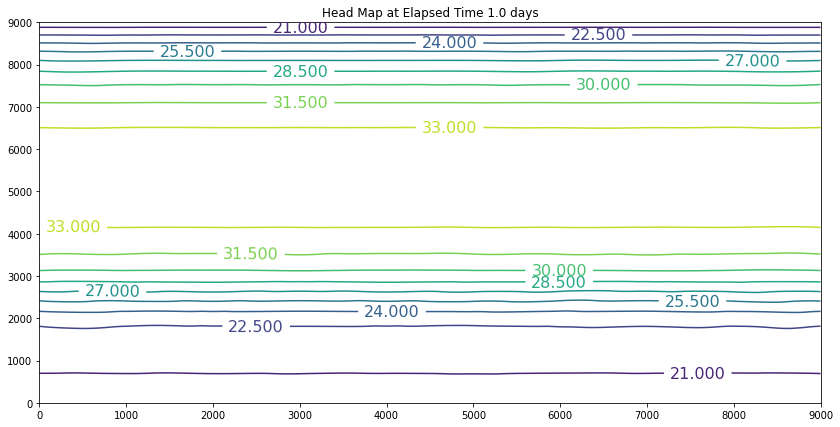

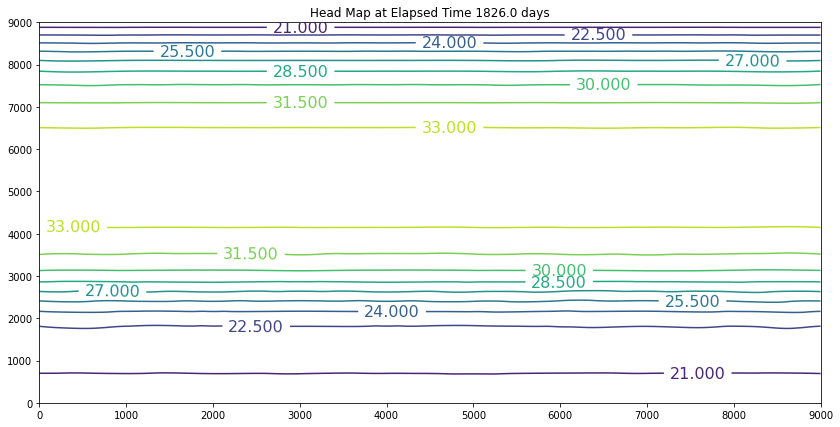

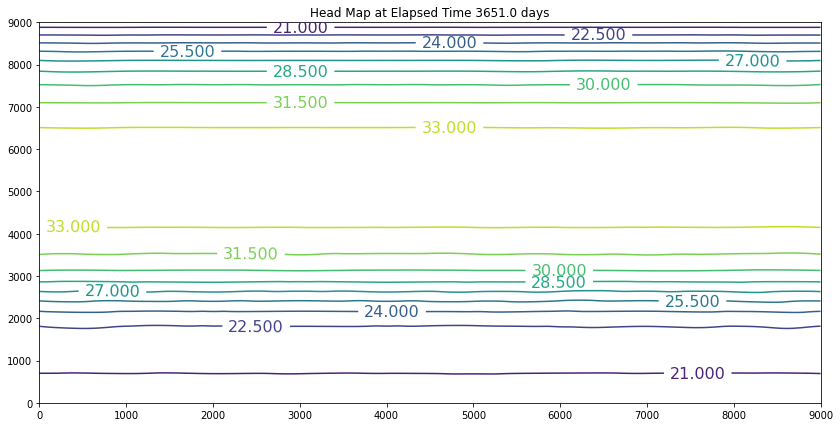

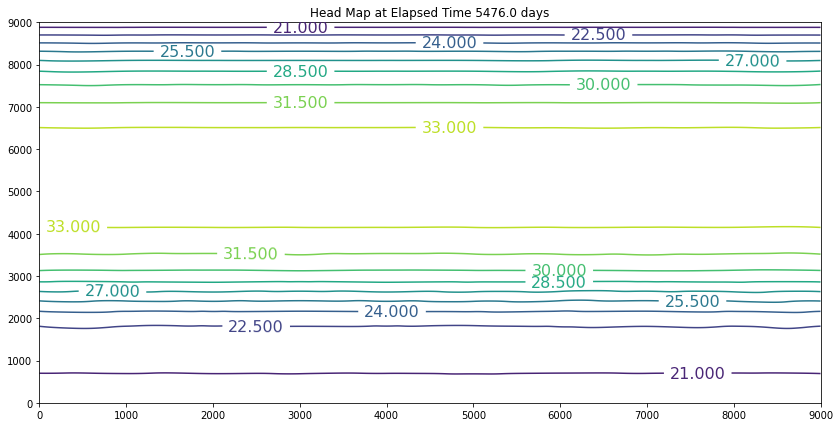

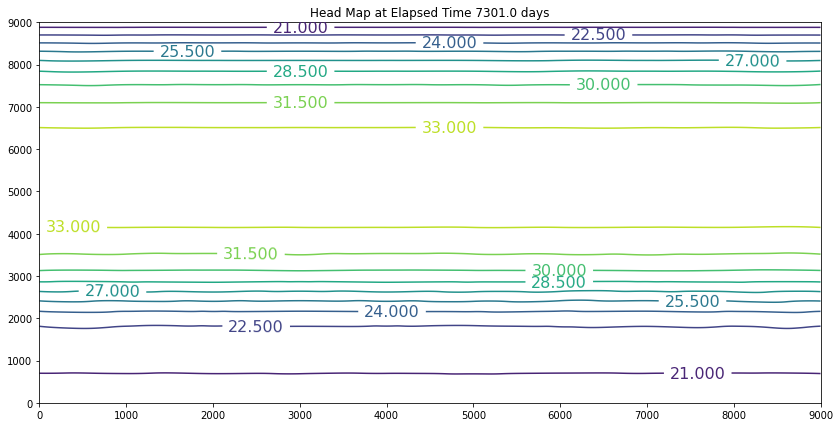

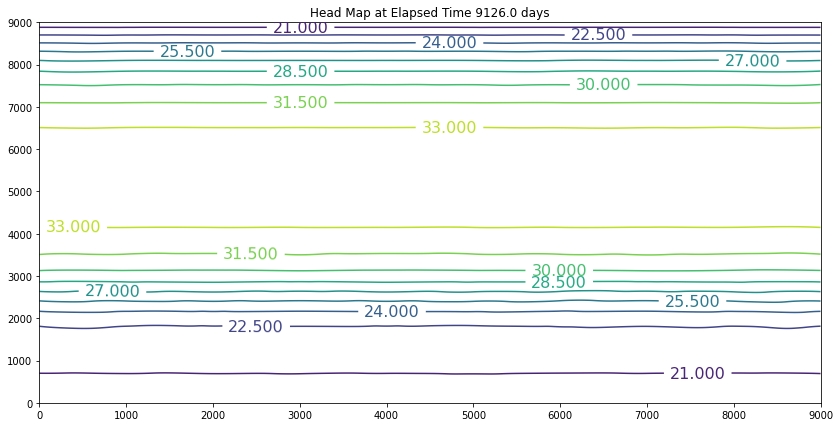

In [2]:
%reset -f

def sse(matrix1,matrix2):
    sse=0.0
    nr=len(matrix1) # get row count
    nc=len(matrix1[0]) # get column count
    for ir in range(nr):
        for jc in range(nc):
            sse=sse+(matrix1[ir][jc]-matrix2[ir][jc])**2
    return(sse)

def update(matrix1,matrix2):
    nr=len(matrix1) # get row count
    nc=len(matrix1[0]) # get column count
    ##print(nr,nc)
    for ir in range(nr):
        for jc in range(nc):
            ##print(ir,jc)
            matrix2[ir][jc]=matrix1[ir][jc]
    return(matrix2)

def writearray(matrix):
    nr=len(matrix) # get row count
    nc=len(matrix[0]) # get column count
    import numpy as np
    new_list = list(np.around(np.array(matrix), 0))    
    for ir in range(nr):
        print(ir,new_list[ir][:])
    return()
import numpy
localfile = open("input8.txt","r") # connect and read file for 2D gw model
deltax = float(localfile.readline())
deltay = float(localfile.readline())
deltaz = float(localfile.readline())
deltat = float(localfile.readline()) # time step
nrows = int(localfile.readline())
ncols = int(localfile.readline())
tolerance = float(localfile.readline())
maxiter = int(localfile.readline()) # max iter per time step
maxtime = int(localfile.readline()) # total time steps
iprint = int(localfile.readline()) # output every iprint steps
distancex = [] # empty list
distancex.append([float(n) for n in localfile.readline().strip().split()])
distancey = [] # empty list
distancey.append([float(n) for n in localfile.readline().strip().split()])
boundarytop = [] #empty list
boundarytop.append([float(n) for n in localfile.readline().strip().split()])
boundarybottom = [] #empty list
boundarybottom.append([int(n) for n in localfile.readline().strip().split()])
boundaryleft = [] #empty list
boundaryleft.append([int(n) for n in localfile.readline().strip().split()])
boundaryright = [] #empty list
boundaryright.append([int(n) for n in localfile.readline().strip().split()])
head =[] # empty list
for irow in range(nrows):
        head.append([float(n) for n in localfile.readline().strip().split()])
#writearray(head)
hydcondx = [] # empty list
for irow in range(nrows):
        hydcondx.append([float(n) for n in localfile.readline().strip().split()])
#writearray(hydcondx)
hydcondy = [] # empty list
for irow in range(nrows):
        hydcondy.append([float(n) for n in localfile.readline().strip().split()])
#writearray(hydcondy)
storage = [] # empty list
for irow in range(nrows):
        storage.append([float(n) for n in localfile.readline().strip().split()])
#writearray(storage)
pumping = [] # empty list
for irow in range(nrows):
        pumping.append([float(n) for n in localfile.readline().strip().split()])
#writearray(pumping)
localfile.close() # Disconnect the file
##
amat = [[0 for j in range(ncols)] for i in range(nrows)]
bmat = [[0 for j in range(ncols)] for i in range(nrows)]
cmat = [[0 for j in range(ncols)] for i in range(nrows)]
dmat = [[0 for j in range(ncols)] for i in range(nrows)]
qrat = [[0 for j in range(ncols)] for i in range(nrows)]
## Net Pumping Array
for irow in range(nrows):
    for jcol in range(ncols):
        qrat[irow][jcol] = (-1*deltat*pumping[irow][jcol]) /(deltax*deltay*storage[irow][jcol])
## Headold array initialize
headold = [[0 for jc in range(ncols)] for ir in range(nrows)] #force a new matrix
headnew = [[0 for jc in range(ncols)] for ir in range(nrows)]
for irow in range(nrows): # element-by-element assignment
    for jcol in range(ncols):
        headold[irow][jcol]=head[irow][jcol]
        headnew[irow][jcol]=head[irow][jcol]
print(hex(id(head)),hex(id(headold)),hex(id(headnew)))

## Time Stepping Outer Loop
for itime in range(maxtime):

#### Single Time Step Update Loop
    tolflag = False
    for iteration in range(maxiter):
        for irow in range(nrows):
            for jcol in range(ncols):
                head[irow][jcol]=headnew[irow][jcol]
# Boundary Conditions
## Transmissivity Arrays
        for irow in range(1,nrows-1):
            for jcol in range(1,ncols-1):
                amat[irow][jcol] = ((head[irow-1][jcol  ] * hydcondx[irow-1][jcol  ]+ head[irow  ][jcol  ] * hydcondx[irow  ][jcol  ]) * deltaz ) /(2.0*deltax**2)
                bmat[irow][jcol] = ((head[irow  ][jcol  ] * hydcondx[irow  ][jcol  ]+ head[irow+1][jcol  ] * hydcondx[irow+1][jcol  ]) * deltaz ) /(2.0*deltax**2)
                cmat[irow][jcol] = ((head[irow  ][jcol-1] * hydcondy[irow  ][jcol-1]+ head[irow  ][jcol  ] * hydcondy[irow  ][jcol  ]) * deltaz ) /(2.0*deltay**2)
                dmat[irow][jcol] = ((head[irow  ][jcol  ] * hydcondy[irow  ][jcol  ]+ head[irow  ][jcol+1] * hydcondy[irow  ][jcol+1]) * deltaz ) /(2.0*deltay**2)
# Boundary Conditions
# first and last row special == no flow boundaries
        for jcol in range(ncols):
            if boundarytop[0][jcol] == 0: # no - flow at top
                head [0][jcol ] = head[1][jcol ]
            if boundarybottom[0][ jcol ] == 0: # no - flow at bottom
                head [nrows-1][jcol ] = head[nrows-2][jcol ]
# first and last column special == no flow boundaries     
        for irow in range(nrows): 
            if  boundaryleft[0][ irow ] == 0:
                head[irow][0] = head [irow][1] # no - flow at left
            if boundaryright[0][ irow ] == 0: 
                head [irow][ncols-1] = head[ irow ][ncols-2] # no - flow at right
# interior updates
        for irow in range(1,nrows-1):
            for jcol in range(1,ncols-1):
                head[irow][jcol]= (headold[irow][jcol] + qrat[irow][jcol] 
                                   +amat[irow][jcol]*head[irow-1][jcol  ]
                                   +bmat[irow][jcol]*head[irow+1][jcol  ] 
                                   +cmat[irow][jcol]*head[irow  ][jcol-1] 
                                   +dmat[irow][jcol]*head[irow  ][jcol+1])/(amat[ irow][jcol ]+ bmat[ irow][jcol ]+ cmat[ irow][jcol ]+ dmat[ irow][jcol ] +1.0)

# test for stopping iterations
        percentdiff = sse(head,headnew)
        if  percentdiff <= tolerance:
            break
        for irow in range(nrows):
            for jcol in range(ncols):
                headnew[irow][jcol]=head[irow][jcol]
### End Single Step Update Loop
# update values at end of a time step
    for irow in range(nrows):
        for jcol in range(ncols):
            headold[irow][jcol]=head[irow][jcol]
    if itime % iprint == 0:
        print("Elapsed Time ",round(deltat*(itime+1),1)," days")
        print("Closure Error = ",round(percentdiff,12))
        b = numpy.array(head)
        p = numpy.array(pumping)
        print("Minimum Head",round(b.min(),3))
        print("Pumpage Total",round(deltat*(itime+1)*p.sum(),3)," cubic meters")
        print("Head End of Timestep \n ----")
        writearray(head)
        print("--------\n--------")
        my_xyz = [] # empty list
        for irow in range(nrows):
            for jcol in range(ncols):
                my_xyz.append([distancex[0][jcol],distancey[0][irow],head[irow][jcol]])
        import pandas
        my_xyz = pandas.DataFrame(my_xyz) # convert into a data frame
#print(my_xyz) # activate to examine the dataframe
        import numpy 
        import matplotlib.pyplot
        from scipy.interpolate import griddata
# extract lists from the dataframe
        coord_x = my_xyz[0].values.tolist() # column 0 of dataframe
        coord_y = my_xyz[1].values.tolist() # column 1 of dataframe
        coord_z = my_xyz[2].values.tolist() # column 2 of dataframe
        coord_xy = numpy.column_stack((coord_x, coord_y))
# Set plotting range in original data units
        lon = numpy.linspace(min(coord_x), max(coord_x), 300)
        lat = numpy.linspace(min(coord_y), max(coord_y), 80)
        X, Y = numpy.meshgrid(lon, lat)
# Grid the data; use linear interpolation (choices are nearest, linear, cubic)
        Z = griddata(numpy.array(coord_xy), numpy.array(coord_z), (X, Y), method='cubic')
# Build the map
        fig, ax = matplotlib.pyplot.subplots()
        fig.set_size_inches(14, 7)
        CS = ax.contour(X, Y, Z, levels = 12)
        ax.clabel(CS, inline=2, fontsize=16)
        ax.set_title('Head Map at Elapsed Time '+ str(round(deltat*(itime+1),1))+' days')
## End Time Stepping Outer Loop


print("End Simulation")

The results above are the pre-development conditions. The file was created by running the script once with all the heads set to 20. Then at the end of the run (30 years), the output heads were pasted back into the input file, and it was rerun. This process was repeated several times until the program ran through all the time steps using only a single iteration and the error term essentially reported as a small constant value. At this condition, the system was deemed to be at equilibrium.

Examination of the output shows that the contour lines are parallel to the swamp and the river (bottom and top) and slope from the middle (Y == 5500 meters) towards each boundary. The highest plotted water elevation is 34 meters, which would be a depth of about 6 meters beneath the town of Hubbleville. The high “ridge” is called a groundwater divide. All water South of the divide flows to the swamp, whereas all water North of the divide flows to the river.

Now we will activate the pumping. The pumping rate is positive 210,000 cubic meters per day. The recharge rate is a negative 10,000 cubic meters per day, so net pumping is 190,000 cubic meters per day. We will change the contents of the single well field cell, rename the file, and rerun the script.

In [3]:
%reset -f

def sse(matrix1,matrix2):
    sse=0.0
    nr=len(matrix1) # get row count
    nc=len(matrix1[0]) # get column count
    for ir in range(nr):
        for jc in range(nc):
            sse=sse+(matrix1[ir][jc]-matrix2[ir][jc])**2
    return(sse)

def update(matrix1,matrix2):
    nr=len(matrix1) # get row count
    nc=len(matrix1[0]) # get column count
    ##print(nr,nc)
    for ir in range(nr):
        for jc in range(nc):
            ##print(ir,jc)
            matrix2[ir][jc]=matrix1[ir][jc]
    return(matrix2)

def writearray(matrix):
    nr=len(matrix) # get row count
    nc=len(matrix[0]) # get column count
    import numpy as np
    new_list = list(np.around(np.array(matrix), 0))    
    for ir in range(nr):
        print(ir,new_list[ir][:])
    return()
import numpy
localfile = open("input8M.txt","r") # connect and read file for 2D gw model
deltax = float(localfile.readline())
deltay = float(localfile.readline())
deltaz = float(localfile.readline())
deltat = float(localfile.readline()) # time step
nrows = int(localfile.readline())
ncols = int(localfile.readline())
tolerance = float(localfile.readline())
maxiter = int(localfile.readline()) # max iter per time step
maxtime = int(localfile.readline()) # total time steps
iprint = int(localfile.readline()) # output every iprint steps
distancex = [] # empty list
distancex.append([float(n) for n in localfile.readline().strip().split()])
distancey = [] # empty list
distancey.append([float(n) for n in localfile.readline().strip().split()])
boundarytop = [] #empty list
boundarytop.append([float(n) for n in localfile.readline().strip().split()])
boundarybottom = [] #empty list
boundarybottom.append([int(n) for n in localfile.readline().strip().split()])
boundaryleft = [] #empty list
boundaryleft.append([int(n) for n in localfile.readline().strip().split()])
boundaryright = [] #empty list
boundaryright.append([int(n) for n in localfile.readline().strip().split()])
head =[] # empty list
for irow in range(nrows):
        head.append([float(n) for n in localfile.readline().strip().split()])
#writearray(head)
hydcondx = [] # empty list
for irow in range(nrows):
        hydcondx.append([float(n) for n in localfile.readline().strip().split()])
#writearray(hydcondx)
hydcondy = [] # empty list
for irow in range(nrows):
        hydcondy.append([float(n) for n in localfile.readline().strip().split()])
#writearray(hydcondy)
storage = [] # empty list
for irow in range(nrows):
        storage.append([float(n) for n in localfile.readline().strip().split()])
#writearray(storage)
pumping = [] # empty list
for irow in range(nrows):
        pumping.append([float(n) for n in localfile.readline().strip().split()])
#writearray(pumping)
localfile.close() # Disconnect the file
##
amat = [[0 for j in range(ncols)] for i in range(nrows)]
bmat = [[0 for j in range(ncols)] for i in range(nrows)]
cmat = [[0 for j in range(ncols)] for i in range(nrows)]
dmat = [[0 for j in range(ncols)] for i in range(nrows)]
qrat = [[0 for j in range(ncols)] for i in range(nrows)]
## Net Pumping Array
for irow in range(nrows):
    for jcol in range(ncols):
        qrat[irow][jcol] = (-1*deltat*pumping[irow][jcol]) /(deltax*deltay*storage[irow][jcol])
## Headold array initialize
headold = [[0 for jc in range(ncols)] for ir in range(nrows)] #force a new matrix
headnew = [[0 for jc in range(ncols)] for ir in range(nrows)]
for irow in range(nrows): # element-by-element assignment
    for jcol in range(ncols):
        headold[irow][jcol]=head[irow][jcol]
        headnew[irow][jcol]=head[irow][jcol]
print(hex(id(head)),hex(id(headold)),hex(id(headnew)))

## Time Stepping Outer Loop
for itime in range(maxtime):

#### Single Time Step Update Loop
    tolflag = False
    for iteration in range(maxiter):
        for irow in range(nrows):
            for jcol in range(ncols):
                head[irow][jcol]=headnew[irow][jcol]
# Boundary Conditions
## Transmissivity Arrays
        for irow in range(1,nrows-1):
            for jcol in range(1,ncols-1):
                amat[irow][jcol] = ((head[irow-1][jcol  ] * hydcondx[irow-1][jcol  ]+ head[irow  ][jcol  ] * hydcondx[irow  ][jcol  ]) * deltaz ) /(2.0*deltax**2)
                bmat[irow][jcol] = ((head[irow  ][jcol  ] * hydcondx[irow  ][jcol  ]+ head[irow+1][jcol  ] * hydcondx[irow+1][jcol  ]) * deltaz ) /(2.0*deltax**2)
                cmat[irow][jcol] = ((head[irow  ][jcol-1] * hydcondy[irow  ][jcol-1]+ head[irow  ][jcol  ] * hydcondy[irow  ][jcol  ]) * deltaz ) /(2.0*deltay**2)
                dmat[irow][jcol] = ((head[irow  ][jcol  ] * hydcondy[irow  ][jcol  ]+ head[irow  ][jcol+1] * hydcondy[irow  ][jcol+1]) * deltaz ) /(2.0*deltay**2)
# Boundary Conditions
# first and last row special == no flow boundaries
        for jcol in range(ncols):
            if boundarytop[0][jcol] == 0: # no - flow at top
                head [0][jcol ] = head[1][jcol ]
            if boundarybottom[0][ jcol ] == 0: # no - flow at bottom
                head [nrows-1][jcol ] = head[nrows-2][jcol ]
# first and last column special == no flow boundaries     
        for irow in range(nrows): 
            if  boundaryleft[0][ irow ] == 0:
                head[irow][0] = head [irow][1] # no - flow at left
            if boundaryright[0][ irow ] == 0: 
                head [irow][ncols-1] = head[ irow ][ncols-2] # no - flow at right
# interior updates
        for irow in range(1,nrows-1):
            for jcol in range(1,ncols-1):
                head[irow][jcol]= (headold[irow][jcol] + qrat[irow][jcol] 
                                   +amat[irow][jcol]*head[irow-1][jcol  ]
                                   +bmat[irow][jcol]*head[irow+1][jcol  ] 
                                   +cmat[irow][jcol]*head[irow  ][jcol-1] 
                                   +dmat[irow][jcol]*head[irow  ][jcol+1])/(amat[ irow][jcol ]+ bmat[ irow][jcol ]+ cmat[ irow][jcol ]+ dmat[ irow][jcol ] +1.0)

# test for stopping iterations
        percentdiff = sse(head,headnew)
        if  percentdiff <= tolerance:
            break
        for irow in range(nrows):
            for jcol in range(ncols):
                headnew[irow][jcol]=head[irow][jcol]
### End Single Step Update Loop
# update values at end of a time step
    for irow in range(nrows):
        for jcol in range(ncols):
            headold[irow][jcol]=head[irow][jcol]
    if itime % iprint == 0:
        print("Elapsed Time ",round(deltat*(itime+1),1)," days")
        print("Closure Error = ",round(percentdiff,12))
        b = numpy.array(head)
        p = numpy.array(pumping)
        print("Minimum Head",round(b.min(),3))
        print("Pumpage Total",round(deltat*(itime+1)*p.sum(),3)," cubic meters")
        print("Head End of Timestep \n ----")
        writearray(head)
        print("--------\n--------")
        print(hex(id(head)),hex(id(headold)))
        my_xyz = [] # empty list
        for irow in range(nrows):
            for jcol in range(ncols):
                my_xyz.append([distancex[0][jcol],distancey[0][irow],head[irow][jcol]])
        import pandas
        my_xyz = pandas.DataFrame(my_xyz) # convert into a data frame
#print(my_xyz) # activate to examine the dataframe
        import numpy 
        import matplotlib.pyplot
        from scipy.interpolate import griddata
# extract lists from the dataframe
        coord_x = my_xyz[0].values.tolist() # column 0 of dataframe
        coord_y = my_xyz[1].values.tolist() # column 1 of dataframe
        coord_z = my_xyz[2].values.tolist() # column 2 of dataframe
        coord_xy = numpy.column_stack((coord_x, coord_y))
# Set plotting range in original data units
        lon = numpy.linspace(min(coord_x), max(coord_x), 300)
        lat = numpy.linspace(min(coord_y), max(coord_y), 80)
        X, Y = numpy.meshgrid(lon, lat)
# Grid the data; use linear interpolation (choices are nearest, linear, cubic)
        Z = griddata(numpy.array(coord_xy), numpy.array(coord_z), (X, Y), method='cubic')
# Build the map
        fig, ax = matplotlib.pyplot.subplots()
        fig.set_size_inches(14, 7)
        CS = ax.contour(X, Y, Z, levels = 12)
        ax.clabel(CS, inline=2, fontsize=16)
        ax.set_title('Head Map at Elapsed Time '+ str(round(deltat*(itime+1),1))+' days')
## End Time Stepping Outer Loop


print("End Simulation")

0xffff6bea3500 0xffff6bddd480 0xffff6bddd1c0
Elapsed Time  1.0  days
Closure Error =  0.000171892321
Minimum Head 20.0
Pumpage Total -780000.0  cubic meters
Head End of Timestep 
 ----
0 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
1 [21. 21. 21. 21. 21. 21. 21. 21. 21. 21.]
2 [23. 23. 23. 23. 23. 23. 23. 23. 23. 23.]
3 [29. 29. 29. 29. 29. 29. 29. 29. 29. 29.]
4 [33. 33. 33. 33. 33. 33. 33. 33. 33. 33.]
5 [34. 34. 34. 34. 34. 34. 34. 34. 34. 34.]
6 [34. 34. 34. 34. 33. 34. 34. 34. 34. 34.]
7 [32. 32. 32. 32. 32. 32. 32. 32. 32. 32.]
8 [28. 28. 28. 28. 28. 28. 28. 28. 28. 28.]
9 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
--------
--------
0xffff6bea3500 0xffff6bddd480


Elapsed Time  3651.0  days
Closure Error =  2.134826e-06
Minimum Head 14.238
Pumpage Total -2847780000.0  cubic meters
Head End of Timestep 
 ----
0 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
1 [21. 21. 21. 21. 21. 21. 21. 21. 21. 21.]
2 [23. 23. 23. 23. 23. 23. 23. 23. 23. 23.]
3 [30. 30. 29. 29. 29. 29. 30. 30. 30. 30.]
4 [33. 33. 32. 32. 31. 32. 33. 34. 34. 34.]
5 [34. 34. 33. 31. 29. 31. 33. 35. 35. 35.]
6 [33. 33. 32. 28. 14. 28. 32. 34. 35. 35.]
7 [31. 31. 30. 28. 26. 29. 31. 32. 33. 33.]
8 [27. 27. 27. 26. 25. 26. 27. 28. 28. 28.]
9 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
--------
--------
0xffff6bea3500 0xffff6bddd480


Elapsed Time  7301.0  days
Closure Error =  0.000741421151
Minimum Head 10.672
Pumpage Total -5694780000.0  cubic meters
Head End of Timestep 
 ----
0 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
1 [21. 21. 21. 21. 21. 21. 21. 21. 21. 21.]
2 [23. 23. 23. 23. 23. 23. 23. 23. 23. 23.]
3 [29. 29. 29. 28. 28. 28. 29. 29. 29. 29.]
4 [32. 32. 31. 30. 30. 30. 32. 32. 33. 33.]
5 [32. 32. 32. 30. 27. 30. 32. 33. 34. 34.]
6 [32. 32. 30. 27. 11. 27. 31. 33. 34. 34.]
7 [30. 30. 29. 27. 24. 27. 30. 31. 32. 32.]
8 [27. 27. 26. 25. 25. 25. 26. 27. 27. 27.]
9 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
--------
--------
0xffff6bea3500 0xffff6bddd480


The simulation above is the result of the change. The plot is promising because the slope of the
water is still towards the swamp. However, if we examine the plot at 40 years we will
discover we have dewatered the aquifer in the wellfield (at some point the wells would fail). So we can conclude that the swamp is safe, but the town of Hubbleville cannot realistically recover the amount of water they desire.
While we have the model available, we can try different pumping rates to see how much firm yield the town could expect. For the example, lets stipulate that the smallest allowable head in the well field is 5 meters. Our goal is now to determine how large a pumping rate we can use and keep the head at this location greater than 5 meters. The exercise is quite simple, we will change the pumping value and run the script and examine the output. If the head is too small, decrease the pumping, if the head is too large then increase the pumping and we stop when it is just right.

:::{note}
Goldilocks optimization!
:::

By some trial-and-error a net puming rate of 179,930 at Hubbleville preserves the minimum head in the aquifer and delivers a good quantity of water.  

:::{warning}
The numerical values in these examples are entirely invented, 20,000 cubic meters per day is about 3600 gallons per minute, not an unreasonable value but absurd for a mere 5 meters of saturated thickness.  Professional tools like `MODFLOW` do internal error checks to reduce the ability to process absurd values.
:::

0xffff944476c0 0xffff65ebfcc0 0xffff65ebfe00
Elapsed Time  1.0  days
Closure Error =  0.000128377356
Minimum Head 20.0
Pumpage Total -810070.0  cubic meters
Head End of Timestep 
 ----
0 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
1 [21. 21. 21. 21. 21. 21. 21. 21. 21. 21.]
2 [23. 23. 23. 23. 23. 23. 23. 23. 23. 23.]
3 [29. 29. 29. 29. 29. 29. 29. 29. 29. 29.]
4 [33. 33. 33. 33. 33. 33. 33. 33. 33. 33.]
5 [34. 34. 34. 34. 34. 34. 34. 34. 34. 34.]
6 [34. 34. 34. 34. 33. 34. 34. 34. 34. 34.]
7 [32. 32. 32. 32. 32. 32. 32. 32. 32. 32.]
8 [28. 28. 28. 28. 28. 28. 28. 28. 28. 28.]
9 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
--------
--------
0xffff944476c0 0xffff65ebfcc0 0xffff65ebfe00
Elapsed Time  3651.0  days
Closure Error =  0.000989972792
Minimum Head 5.005
Pumpage Total -2957565570.0  cubic meters
Head End of Timestep 
 ----
0 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
1 [21. 21. 21. 21. 21. 21. 21. 21. 21. 21.]
2 [22. 22. 22. 22. 22. 22. 23. 23. 23. 23.]
3 [27. 27. 27. 26. 26. 26. 27. 2

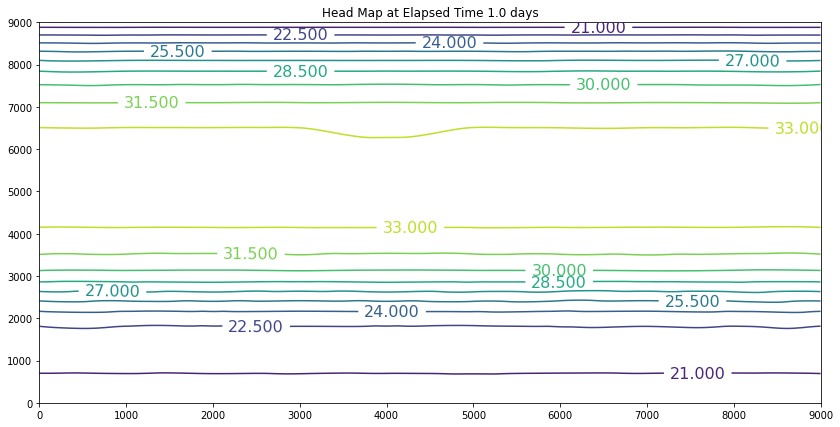

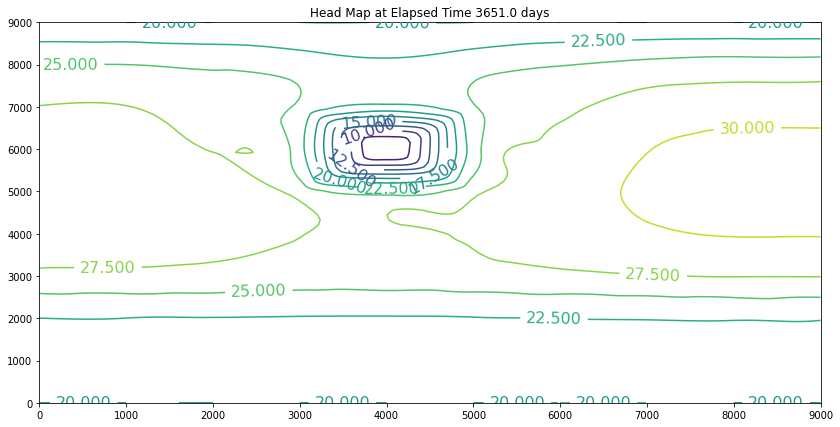

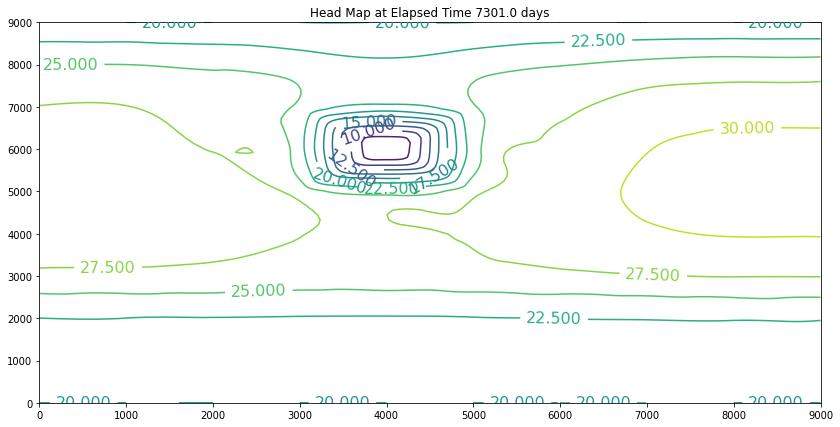

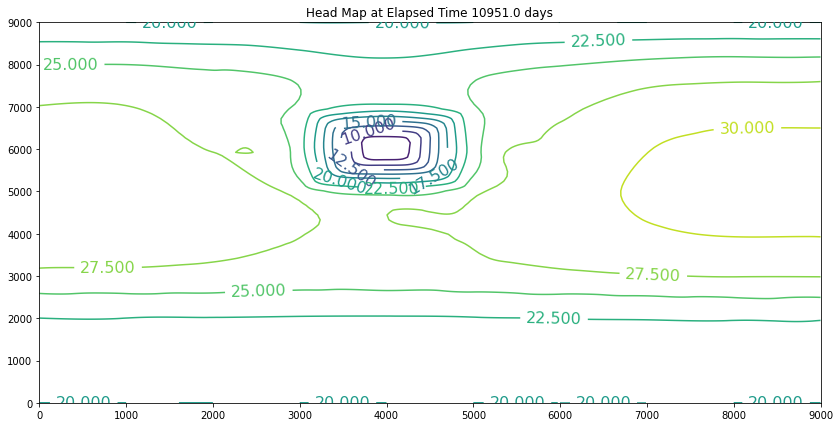

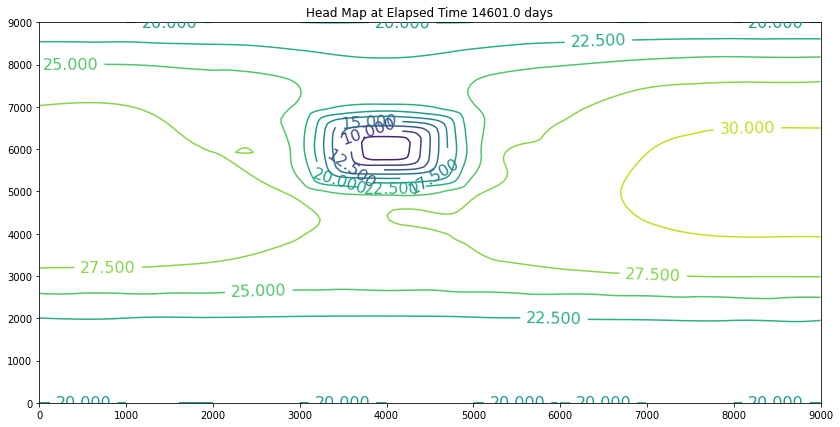

In [4]:
%reset -f

def sse(matrix1,matrix2):
    sse=0.0
    nr=len(matrix1) # get row count
    nc=len(matrix1[0]) # get column count
    for ir in range(nr):
        for jc in range(nc):
            sse=sse+(matrix1[ir][jc]-matrix2[ir][jc])**2
    return(sse)

def update(matrix1,matrix2):
    nr=len(matrix1) # get row count
    nc=len(matrix1[0]) # get column count
    ##print(nr,nc)
    for ir in range(nr):
        for jc in range(nc):
            ##print(ir,jc)
            matrix2[ir][jc]=matrix1[ir][jc]
    return(matrix2)

def writearray(matrix):
    nr=len(matrix) # get row count
    nc=len(matrix[0]) # get column count
    import numpy as np
    new_list = list(np.around(np.array(matrix), 0))    
    for ir in range(nr):
        print(ir,new_list[ir][:])
    return()
import numpy
localfile = open("input8M2.txt","r") # connect and read file for 2D gw model
deltax = float(localfile.readline())
deltay = float(localfile.readline())
deltaz = float(localfile.readline())
deltat = float(localfile.readline()) # time step
nrows = int(localfile.readline())
ncols = int(localfile.readline())
tolerance = float(localfile.readline())
maxiter = int(localfile.readline()) # max iter per time step
maxtime = int(localfile.readline()) # total time steps
iprint = int(localfile.readline()) # output every iprint steps
distancex = [] # empty list
distancex.append([float(n) for n in localfile.readline().strip().split()])
distancey = [] # empty list
distancey.append([float(n) for n in localfile.readline().strip().split()])
boundarytop = [] #empty list
boundarytop.append([float(n) for n in localfile.readline().strip().split()])
boundarybottom = [] #empty list
boundarybottom.append([int(n) for n in localfile.readline().strip().split()])
boundaryleft = [] #empty list
boundaryleft.append([int(n) for n in localfile.readline().strip().split()])
boundaryright = [] #empty list
boundaryright.append([int(n) for n in localfile.readline().strip().split()])
head =[] # empty list
for irow in range(nrows):
        head.append([float(n) for n in localfile.readline().strip().split()])
#writearray(head)
hydcondx = [] # empty list
for irow in range(nrows):
        hydcondx.append([float(n) for n in localfile.readline().strip().split()])
#writearray(hydcondx)
hydcondy = [] # empty list
for irow in range(nrows):
        hydcondy.append([float(n) for n in localfile.readline().strip().split()])
#writearray(hydcondy)
storage = [] # empty list
for irow in range(nrows):
        storage.append([float(n) for n in localfile.readline().strip().split()])
#writearray(storage)
pumping = [] # empty list
for irow in range(nrows):
        pumping.append([float(n) for n in localfile.readline().strip().split()])
#writearray(pumping)
localfile.close() # Disconnect the file
##
amat = [[0 for j in range(ncols)] for i in range(nrows)]
bmat = [[0 for j in range(ncols)] for i in range(nrows)]
cmat = [[0 for j in range(ncols)] for i in range(nrows)]
dmat = [[0 for j in range(ncols)] for i in range(nrows)]
qrat = [[0 for j in range(ncols)] for i in range(nrows)]
## Net Pumping Array
for irow in range(nrows):
    for jcol in range(ncols):
        qrat[irow][jcol] = (-1*deltat*pumping[irow][jcol]) /(deltax*deltay*storage[irow][jcol])
## Headold array initialize
headold = [[0 for jc in range(ncols)] for ir in range(nrows)] #force a new matrix
headnew = [[0 for jc in range(ncols)] for ir in range(nrows)]
for irow in range(nrows): # element-by-element assignment
    for jcol in range(ncols):
        headold[irow][jcol]=head[irow][jcol]
        headnew[irow][jcol]=head[irow][jcol]
print(hex(id(head)),hex(id(headold)),hex(id(headnew)))

## Time Stepping Outer Loop
for itime in range(maxtime):

#### Single Time Step Update Loop
    tolflag = False
    for iteration in range(maxiter):
        for irow in range(nrows):
            for jcol in range(ncols):
                head[irow][jcol]=headnew[irow][jcol]
# Boundary Conditions
## Transmissivity Arrays
        for irow in range(1,nrows-1):
            for jcol in range(1,ncols-1):
                amat[irow][jcol] = ((head[irow-1][jcol  ] * hydcondx[irow-1][jcol  ]+ head[irow  ][jcol  ] * hydcondx[irow  ][jcol  ]) * deltaz ) /(2.0*deltax**2)
                bmat[irow][jcol] = ((head[irow  ][jcol  ] * hydcondx[irow  ][jcol  ]+ head[irow+1][jcol  ] * hydcondx[irow+1][jcol  ]) * deltaz ) /(2.0*deltax**2)
                cmat[irow][jcol] = ((head[irow  ][jcol-1] * hydcondy[irow  ][jcol-1]+ head[irow  ][jcol  ] * hydcondy[irow  ][jcol  ]) * deltaz ) /(2.0*deltay**2)
                dmat[irow][jcol] = ((head[irow  ][jcol  ] * hydcondy[irow  ][jcol  ]+ head[irow  ][jcol+1] * hydcondy[irow  ][jcol+1]) * deltaz ) /(2.0*deltay**2)
# Boundary Conditions
# first and last row special == no flow boundaries
        for jcol in range(ncols):
            if boundarytop[0][jcol] == 0: # no - flow at top
                head [0][jcol ] = head[1][jcol ]
            if boundarybottom[0][ jcol ] == 0: # no - flow at bottom
                head [nrows-1][jcol ] = head[nrows-2][jcol ]
# first and last column special == no flow boundaries     
        for irow in range(nrows): 
            if  boundaryleft[0][ irow ] == 0:
                head[irow][0] = head [irow][1] # no - flow at left
            if boundaryright[0][ irow ] == 0: 
                head [irow][ncols-1] = head[ irow ][ncols-2] # no - flow at right
# interior updates
        for irow in range(1,nrows-1):
            for jcol in range(1,ncols-1):
                head[irow][jcol]= (headold[irow][jcol] + qrat[irow][jcol] 
                                   +amat[irow][jcol]*head[irow-1][jcol  ]
                                   +bmat[irow][jcol]*head[irow+1][jcol  ] 
                                   +cmat[irow][jcol]*head[irow  ][jcol-1] 
                                   +dmat[irow][jcol]*head[irow  ][jcol+1])/(amat[ irow][jcol ]+ bmat[ irow][jcol ]+ cmat[ irow][jcol ]+ dmat[ irow][jcol ] +1.0)

# test for stopping iterations
        percentdiff = sse(head,headnew)
        if  percentdiff <= tolerance:
            break
        for irow in range(nrows):
            for jcol in range(ncols):
                headnew[irow][jcol]=head[irow][jcol]
### End Single Step Update Loop
# update values at end of a time step
    for irow in range(nrows):
        for jcol in range(ncols):
            headold[irow][jcol]=head[irow][jcol]
    if itime % iprint == 0:
        print("Elapsed Time ",round(deltat*(itime+1),1)," days")
        print("Closure Error = ",round(percentdiff,12))
        b = numpy.array(head)
        p = numpy.array(pumping)
        print("Minimum Head",round(b.min(),3))
        print("Pumpage Total",round(deltat*(itime+1)*p.sum(),3)," cubic meters")
        print("Head End of Timestep \n ----")
        writearray(head)
        print("--------\n--------")
        print(hex(id(head)),hex(id(headold)),hex(id(headnew)))
        my_xyz = [] # empty list
        for irow in range(nrows):
            for jcol in range(ncols):
                my_xyz.append([distancex[0][jcol],distancey[0][irow],head[irow][jcol]])
        import pandas
        my_xyz = pandas.DataFrame(my_xyz) # convert into a data frame
#print(my_xyz) # activate to examine the dataframe
        import numpy 
        import matplotlib.pyplot
        from scipy.interpolate import griddata
# extract lists from the dataframe
        coord_x = my_xyz[0].values.tolist() # column 0 of dataframe
        coord_y = my_xyz[1].values.tolist() # column 1 of dataframe
        coord_z = my_xyz[2].values.tolist() # column 2 of dataframe
        coord_xy = numpy.column_stack((coord_x, coord_y))
# Set plotting range in original data units
        lon = numpy.linspace(min(coord_x), max(coord_x), 300)
        lat = numpy.linspace(min(coord_y), max(coord_y), 80)
        X, Y = numpy.meshgrid(lon, lat)
# Grid the data; use linear interpolation (choices are nearest, linear, cubic)
        Z = griddata(numpy.array(coord_xy), numpy.array(coord_z), (X, Y), method='cubic')
# Build the map
        fig, ax = matplotlib.pyplot.subplots()
        fig.set_size_inches(14, 7)
        CS = ax.contour(X, Y, Z, levels = 12)
        ax.clabel(CS, inline=2, fontsize=16)
        ax.set_title('Head Map at Elapsed Time '+ str(round(deltat*(itime+1),1))+' days')
## End Time Stepping Outer Loop


print("End Simulation")

These examples introduced an important computational hydraulics problem – namely that of flow in a porous medium. The governing equation of motion is Darcy’s law. We computed the heads using a variety of methods, but mostly focused on Jacobi iteration because for these kinds of problems it is a stable solution technique. It is not particularly computationally efficient, but it works.

Focus was also on code reuse so the reader can look back over the examples and see the evolution of the code as the problem got more complex.

Most importantly, while not apparent, we have replicated much of the internal functionality of the professional code `MODFLOW` which we could compare our work to if we had to use the script for something the professional code does not do easily. The scripts here are very crude – to professionalize them we would want to add the concept of “layers” so we could do 3D models, and want to generalize the file reading components of the tool. We would also want to move much of the computation engine components into their own prototype functions so the structure of the program is easier to understand and maintain. Nevertheless, if you have worked this far, you have seen what’s under the hood of a groundwater flow code.